<a href="https://colab.research.google.com/github/Alveuz/Intro2MLwithPython/blob/master/notebooks/03FromReg2ClasswAns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos Clásicos de ML con ``Scikit Learn``

<img src="https://docs.google.com/uc?export=download&id=1CIfbX5jBvNjuSQnJechEvnawuMEa5QTq" width="300" align="middle">

---

## Contenido de la Sesión


1. Regresión con otros Algoritmos
          1.1. Selección de Variables: Filtros.
            1.1.1. Menor Varianza.
            1.1.2. Univariable.
          1.2. Selección de Variables: Envoltorios.
            1.2.1. Eliminación Recursiva.
          1.3. Validación Cruzada (CV).
          1.4. Predicción.
          1.5. Análisis de Resultados.

2. Clasificación Binaria.
          2.0. Conjuntos de datos sintéticos
          2.1. Clasificadores RL/KNN/DT/SVM
            - Evaluación de Clasificadores
          2.2. CV para
            2.2.1. Selección de Variables Recursiva.
            2.2.2. Sintonización de parámetros.

3. Ejercicio/Tarea: Predecir si sobrevive un pasajero del Titanic


by GSB

---
# 1. Regresión con otros Algoritmos

### Comparación de Regresores (LRM vs KNN vs DT) usando el caso de Generación de Energía para un Generador de Ciclo Combinado [02: Regresión Lineal con Scikit Learn](02-RegresionLinealwAns.ipynb)

### Inicialización del Modelo usando ``Pipelines``

<img src="https://docs.google.com/uc?export=download&id=1D4d8y7ENGmDwt-rcbs28p1NoQ2LpFSsk" width="800" align="middle">

**Pensamiento de Programador**:

Dentro de un ``pipeline``, para manipular los parámetros del modelo o para obtener el nombre de las variables utilizadas por modelo al aplicarle ``PolynomialFeatures``, conveniene más crear una **instancia por cada estimador**.

Secuencia de Pasos para el PP/Creación de Variables:

    Paso 1: ajustar el "escalador" al conjunto de ENTRENAMIENTO.
    Paso 2: use el "escalador" para transformar el conjunto de ENTRENAMIENTO.
    Paso 3: use el conjunto de ENTRENAMIENTO transformado para entrenar el modelo con la función ``fit``.
    Paso 4: use el "escalador" para transformar el conjunto de PRUEBA.
    Paso 5: prediga usando el modelo entrenado y el conjunto de PRUEBA transformado.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

import numpy as np
import pandas as pd

from google.colab import data_table

#--------
### LOAD DATA 

url = 'https://raw.githubusercontent.com/Alveuz/RandomDataSets/master/CombinedCyclePowerGen/Folds5x2_pp.csv'
ccpp_df = pd.read_csv(url)

#--------
### CREATE PIPELINES
no_poly = 5

std_sclr = StandardScaler()
sclr_01 = MinMaxScaler()

lr_m  = LinearRegression()
knn_m = KNeighborsRegressor(n_neighbors=5)
dt_m  = DecisionTreeRegressor(criterion='mse',
                             max_depth=5,
                             min_samples_split = 20, 
                            #  min_samples_leaf = 10, 
                             random_state=0)

polyFt_m = PolynomialFeatures(no_poly)

#--------
### SPLIT DATA INTO TRAIN AND TEST DATASETS

X_ccpp = ccpp_df.iloc[:,0:4]
y_ccpp = ccpp_df['PE']

X_train, X_test, y_train, y_test = train_test_split(X_ccpp, y_ccpp, 
                                                    test_size=0.3, 
                                                    random_state=1)


---
### Selección de Variables con ``SkLearn``

#### **1.1. Filtros**

- Previos al entrenamiento del modelo

##### **1.1.1. Filtro de poca Varianza**

- Se utiliza exclusivamente sobre la matriz de características ``X``.

En nuestro ejercicio de los regresores, este filtro eliminará las variables con varianza menor a 0.01

In [ ]:
from sklearn.feature_selection import VarianceThreshold

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

sel = VarianceThreshold(threshold=(0.01))
X_train_sel = sel.fit_transform(X_train_tmp)

#Obtain a mask of True and False values: 
#true -> feat is selected
#false -> otherwise
ft_sel_msk = sel.get_support()

ft_names = polyFt_m.get_feature_names(X_ccpp.columns)
ft_names = np.asarray(ft_names)
# print('Antes:', ft_names)
# print('Despues:', ft_names[ft_msk])

X_train_sel = pd.DataFrame(X_train_sel,
                   columns=ft_names[ft_sel_msk])

print(X_train_sel)

            AT         V        AP  ...      AP^5   AP RH^4      RH^5
0     0.487044  0.653737  0.670297  ...  0.135312  0.168208  0.177613
1     0.857774  0.695374  0.531436  ...  0.042389  0.010852  0.007719
2     0.558304  0.461566  0.519802  ...  0.037948  0.267086  0.435027
3     0.507362  0.763701  0.287871  ...  0.001977  0.125353  0.353728
4     0.100118  0.325445  0.612624  ...  0.086292  0.156786  0.182030
...        ...       ...       ...  ...       ...       ...       ...
6692  0.812132  0.814591  0.447525  ...  0.017951  0.009295  0.007884
6693  0.702002  0.953025  0.444059  ...  0.017267  0.198520  0.365557
6694  0.247644  0.254093  0.441337  ...  0.016744  0.028150  0.032054
6695  0.545053  0.342349  0.551238  ...  0.050897  0.000241  0.000063
6696  0.458186  0.282384  0.146040  ...  0.000066  0.015942  0.062745

[6697 rows x 59 columns]


##### **1.1.2. Selección de las K mejores variables**

- Selecciona las mejores características basadas en pruebas estadísticas univariadas.
- Se utiliza exclusivamente sobre la matriz de características ``X``.
- Utiliza una función de ``scoring`` para determinar las K mejores variables

En nuestro ejercicio de los regresores, este filtro seleccionará las 50 mejores variables de acuerdo a la prueba F de Fisher.

In [ ]:
import warnings
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

warnings.filterwarnings("ignore")

no_fts = 50

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

sel = SelectKBest(f_regression, k=no_fts)
# sel = SelectKBest(mutual_info_regression, k=no_fts)
X_train_sel = sel.fit_transform(X_train_tmp, y_train)

# f_res, pval = f_regression(X_train_tmp, y_train)
# print(pval<0.001)

#Obtain a mask of True and False values: 
#true -> feat is selected
#false -> otherwise
ft_sel_msk = sel.get_support()

ft_names = polyFt_m.get_feature_names(X_ccpp.columns)
ft_names = np.asarray(ft_names)

X_train_sel = pd.DataFrame(X_train_sel,
                   columns=ft_names[ft_sel_msk])

print(X_train_sel)


            AT         V      AT^2  ...  AT V^2 AP RH       V^5    V^4 AP
0     0.487044  0.653737  0.237211  ...      0.098750  0.119403  0.122427
1     0.857774  0.695374  0.735776  ...      0.083324  0.162589  0.124258
2     0.558304  0.461566  0.311703  ...      0.052345  0.020949  0.023592
3     0.507362  0.763701  0.257416  ...      0.069198  0.259787  0.097925
4     0.100118  0.325445  0.010024  ...      0.004620  0.003651  0.006872
...        ...       ...       ...  ...           ...       ...       ...
6692  0.812132  0.814591  0.659558  ...      0.091554  0.358672  0.197049
6693  0.702002  0.953025  0.492807  ...      0.231515  0.786179  0.366318
6694  0.247644  0.254093  0.061328  ...      0.003546  0.001059  0.001840
6695  0.545053  0.342349  0.297083  ...      0.005093  0.004703  0.007572
6696  0.458186  0.282384  0.209935  ...      0.003067  0.001796  0.000929

[6697 rows x 50 columns]


--- 
#### **1.2. Envoltorios**

- Utilizan la calidad del modelo para añadir o eliminar variables.

##### **1.2.1. Eliminación Recursiva de Variables**

- Utiliza un REGRESOR que asigne pesos a las variables independientes (e.g. los coeficientes de una LRM) ó
- Redución progresiva de las variables 
  $$
  crit:|X_{new}|>=K
  $$
- Su funcionamiento es en 2 pasos y se itera mientras $crit==T$:

  - Se entrena sobre todas las variables disponibles y se obtiene sus pesos (con del parámetro ``coef_``) o la importancia de sus variables (con el atributo ``feature_importances_``).
  - Se eliminan las $\gamma$ variables con menos peso/menor importancia
  $$
  |X_{old}|>|X_{new}|
  $$


In [ ]:
from sklearn.feature_selection import RFE

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

# Temporal models for RFE
lr_tmp  = LinearRegression()
knn_tmp = KNeighborsRegressor(n_neighbors=5)
dt_tmp  = DecisionTreeRegressor(criterion='mse',
                             max_depth=5,
                             min_samples_split = 20, 
                            #  min_samples_leaf = 10, 
                             random_state=0)


rfe_lr = RFE(estimator=lr_tmp, n_features_to_select=50, step=20)
# rfe_knn = RFE(estimator=knn_tmp, n_features_to_select=50, step=20)
rfe_dt = RFE(estimator=dt_tmp, n_features_to_select=50, step=20)

rfe_lr.fit(X_train_tmp, y_train)
# rfe_knn.fit(X_train_tmp, y_train)
rfe_dt.fit(X_train_tmp, y_train)

X_train_rfe_lr = rfe_lr.fit_transform(X_train_tmp, y_train)
X_train_rfe_dt = rfe_dt.fit_transform(X_train_tmp, y_train)

# #Obtain a mask of True and False values: 
# #true -> feat is selected
# #false -> otherwise
ft_rfe_lr_msk = rfe_lr.get_support()
ft_rfe_dt_msk = rfe_dt.get_support()

ft_names = polyFt_m.get_feature_names(X_ccpp.columns)
ft_names = np.asarray(ft_names)

X_train_rfe_lr = pd.DataFrame(X_train_rfe_lr,
                   columns=ft_names[ft_rfe_lr_msk])

print(X_train_rfe_lr)

X_train_rfe_dt = pd.DataFrame(X_train_rfe_dt,
                   columns=ft_names[ft_rfe_dt_msk])

print(X_train_rfe_dt)

np.intersect1d(ft_names[ft_rfe_lr_msk],ft_names[ft_rfe_dt_msk]).shape

             V       V^2    AT^2 V  ...  AT V AP^2 RH  AT V AP RH^2    V^4 AP
0     0.653737  0.427372  0.155074  ...      0.101251      0.106912  0.122427
1     0.695374  0.483545  0.511639  ...      0.063680      0.045296  0.124258
2     0.461566  0.213043  0.143872  ...      0.058950      0.096017  0.023592
3     0.763701  0.583239  0.196589  ...      0.026084      0.073605  0.097925
4     0.325445  0.105914  0.003262  ...      0.008698      0.010098  0.006872
...        ...       ...       ...  ...           ...           ...       ...
6692  0.814591  0.663558  0.537270  ...      0.050298      0.042667  0.197049
6693  0.953025  0.908256  0.469658  ...      0.107874      0.198640  0.366318
6694  0.254093  0.064563  0.015583  ...      0.006159      0.007014  0.001840
6695  0.342349  0.117203  0.101706  ...      0.008201      0.002152  0.007572
6696  0.282384  0.079741  0.059282  ...      0.001586      0.006243  0.000929

[6697 rows x 50 columns]
            RH      AT^2      AT V  ..

(15,)

---
### Inicializar el Pipeline

In [ ]:
model_pl = make_pipeline(sclr_01,
                         polyFt_m,
                         sel,
                         lr_m)

model_knn = make_pipeline(sclr_01,
                          polyFt_m,
                          sel,
                          knn_m)

model_dt = make_pipeline(sclr_01,
                         polyFt_m,
                         sel,
                         dt_m)

---
### 1.3 Entrenamiento de los modelos usando $\underline{\text{Validación Cruzada}}\ (CV)$

<img src="https://docs.google.com/uc?export=download&id=1Jp87zmf057-dRcc1FWBiXQip8FfXIgt-" width="700" align="middle">





In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

#--------
### EVALUATE CV TRAINING ERROR

scoring = {'R2': make_scorer(r2_score), 
           'RMSE': make_scorer(mean_squared_error)}

lrm_scr = cross_validate(model_pl, X_train, y_train, 
                          scoring = scoring, cv=10)
knn_scr = cross_validate(model_knn, X_train, y_train, 
                          scoring = scoring, cv=10)
dt_scr = cross_validate(model_dt, X_train, y_train, 
                         scoring = scoring, cv=10)

print('TRAIN CV ERROR----')

print('LRM_R2: ', np.mean(lrm_scr.get('test_R2')))
print('KNN_R2: ', np.mean(knn_scr.get('test_R2')))
print('DT_R2: ', np.mean(dt_scr.get('test_R2')))

print('LRM_RMSE: ', np.mean(lrm_scr.get('test_RMSE')))
print('KNN_RMSE: ', np.mean(knn_scr.get('test_RMSE')))
print('DT_RMSE: ', np.mean(dt_scr.get('test_RMSE')))

TRAIN CV ERROR----
LRM_R2:  0.9406084833773214
KNN_R2:  0.95008337604592
DT_R2:  0.9330905305540911
LRM_RMSE:  17.276501517859312
KNN_RMSE:  14.526583292792543
DT_RMSE:  19.46764034246271


---
### Visualización del Árbol de Regresión

'ccpp_PE.pdf'

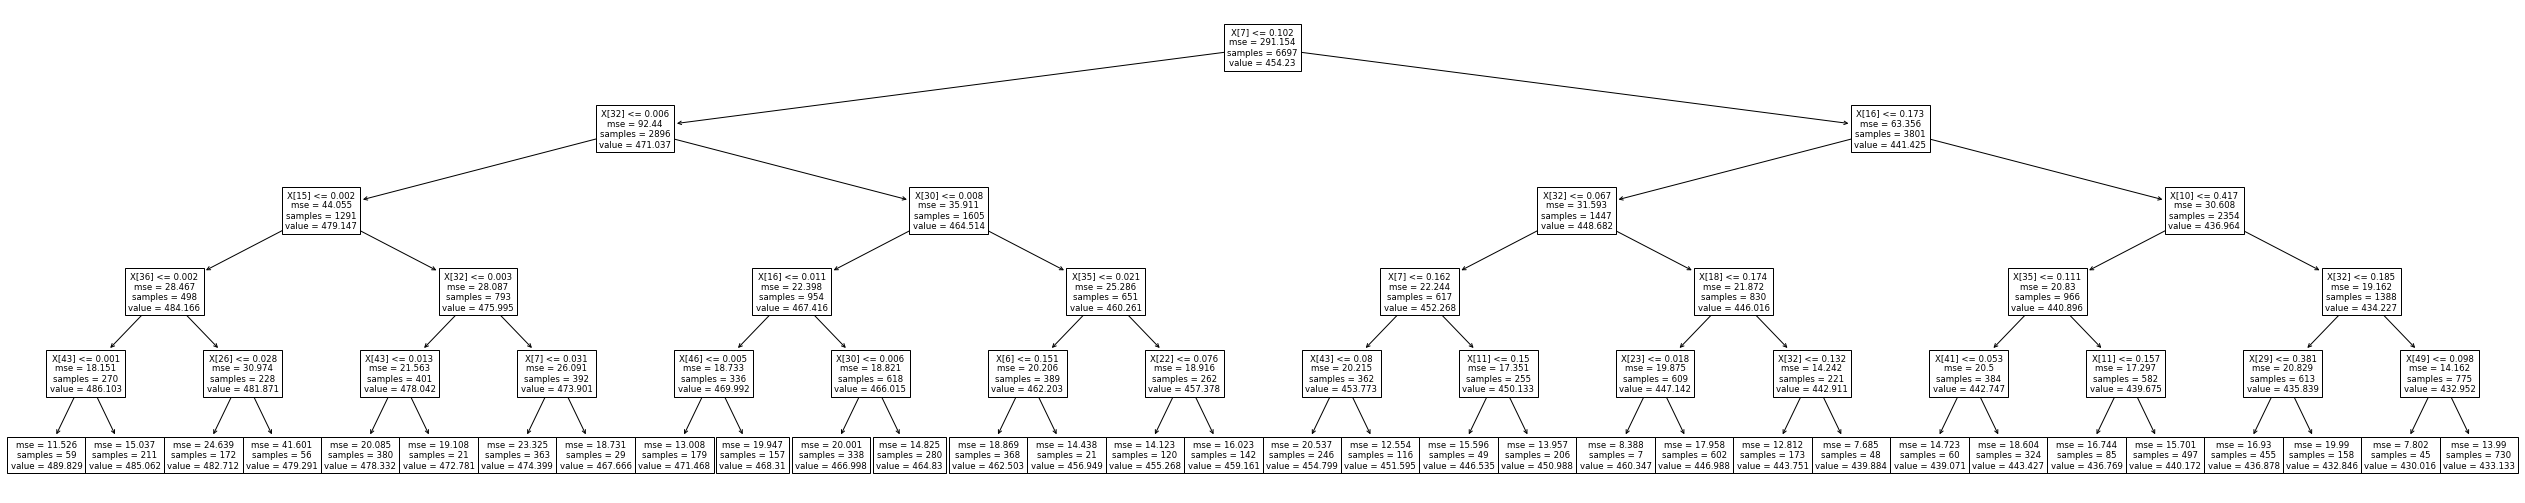

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz 

dt_m1  = DecisionTreeRegressor(criterion='mse',
                              max_depth=5,
                              min_samples_split = 20, 
                              random_state=0)


dt_m1.fit(X_train_sel, y_train[:, np.newaxis]);

f, ax = plt.subplots(figsize=(45, 9))
tree.plot_tree(dt_m1);

dot_data = tree.export_graphviz(dt_m1, out_file=None, 
                                feature_names = ft_names[ft_sel_msk],
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("ccpp_PE") 

---
### 1.4. Predicción con los modelos entrenados sobre el conjunto de PRUEBA


In [ ]:
model_pl.fit(X_train, y_train[:, np.newaxis])
model_knn.fit(X_train, y_train[:, np.newaxis])
model_dt.fit(X_train, y_train[:, np.newaxis]);

# #--------
# ### PREDICT TEST DATA 

y_hat = model_pl.predict(X_test)
y_hatknn = model_knn.predict(X_test)
y_hatdt = model_dt.predict(X_test)

# #--------
# ### PRINT SCORES

print('TEST ERROR----')

print('LR R2: ',r2_score(y_test,y_hat))
print('KNN R2: ',r2_score(y_test,y_hatknn))
print('DT R2: ',r2_score(y_test,y_hatdt))

print('LR RMSE: ',mean_squared_error(y_test,y_hat, squared=False), 'MW')
print('KNN RMSE: ',mean_squared_error(y_test,y_hatknn, squared=False), 'MW')
print('DT RMSE: ',mean_squared_error(y_test,y_hatdt, squared=False), 'MW')

TEST ERROR----
LR R2:  0.9440331462691579
KNN R2:  0.9531937358196361
DT R2:  0.9350742028625183
LR RMSE:  4.037980644460505 MW
KNN RMSE:  3.6927573916526137 MW
DT RMSE:  4.349180494407878 MW


---
### 1.5. Análisis de Resultados usando Gráficas Q-Q 

  Created wheel for seaborn-qqplot: filename=seaborn_qqplot-0.3.2-cp36-none-any.whl size=12632 sha256=c11484e589fc82263dddf39ab53308d8ae7bdaac623dfe668074be52b6597d43
  Stored in directory: /root/.cache/pip/wheels/4e/37/aa/3aa9b433dfe80aebcec84b2970849fc3cb4d6e4f67ff89458b
Successfully built seaborn-qqplot


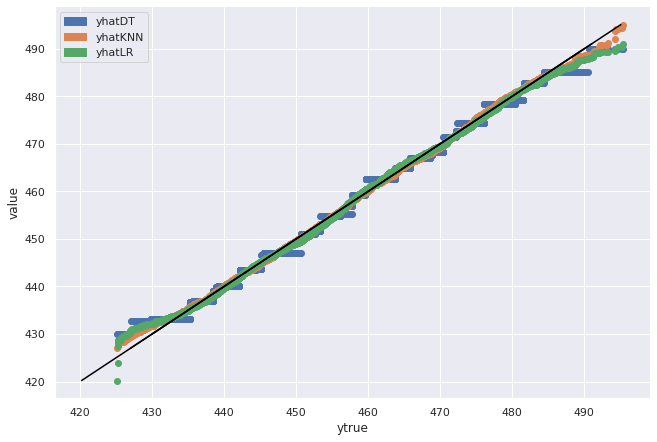

In [ ]:
!pip install seaborn-qqplot;

import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from seaborn_qqplot import qqplot

#--------
### GRAPH QQPLOTS

x_plt = np.linspace(1, y_hat.shape[0], y_hat.shape[0])
mod_res = np.hstack((x_plt[:,np.newaxis],
                     y_test[:,np.newaxis],
                     y_hat,
                     y_hatknn,
                     y_hatdt[:,np.newaxis])) 

mod_res_df = pd.DataFrame(mod_res, 
                          columns=['index', 'ytrue','yhatLR', 'yhatKNN', 'yhatDT'])

mod_res_df_mlt = pd.melt(mod_res_df, 
                         id_vars=['ytrue'],
                         value_vars =['yhatLR', 'yhatKNN', 'yhatDT'])

mod_res_df_mlt['variable'] = mod_res_df_mlt['variable'].astype('category')


qqplot(mod_res_df_mlt, x="ytrue", y="value", 
       hue = "variable", height = 6, aspect = 1.5,
       display_kws={"identity":True});

---
# 2. Clasificación 

---
## 2.0. Datos Sintéticos

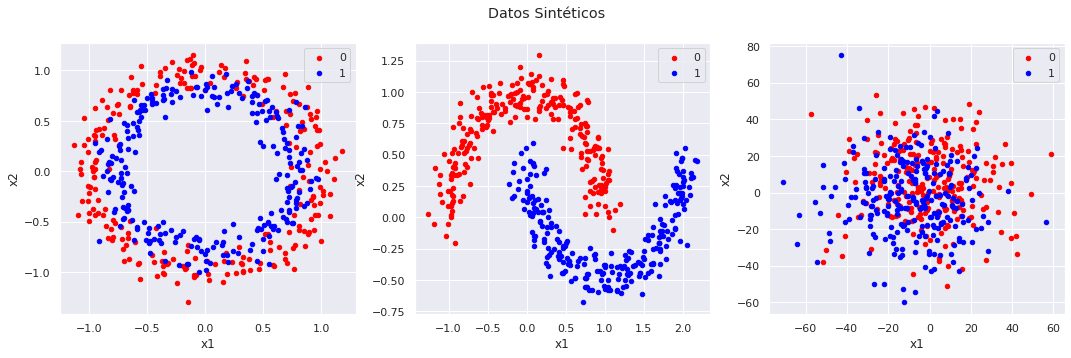

In [ ]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

exp_size = 500

# generate 2d classification dataset
X_circ, y_circ = make_circles(n_samples=exp_size, noise=0.1,
                              random_state=1)
X_moon, y_moon = make_moons(n_samples=exp_size, noise=0.1,
                            random_state=1)

# generate 2d multi classification dataset
X_blob, y_blob = make_blobs(n_samples=exp_size, centers=2, cluster_std= 20,
                            n_features=2,random_state=1)

# scatter plot, dots colored by class value
df_circ = DataFrame(dict(x1 = X_circ[:,0], x2=X_circ[:,1], label=y_circ))
df_moon = DataFrame(dict(x1 = X_moon[:,0], x2=X_moon[:,1], label=y_moon))
colors_bin = {0:'red', 1:'blue'}

df_blob = DataFrame(dict(x1 = X_blob[:,0], x2=X_blob[:,1], label=y_blob))
colors_mult = {0:'red', 1:'blue', 2:'green', 3:'purple'}

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
fig.suptitle('Datos Sintéticos')

grouped = df_circ.groupby('label')
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_moon.groupby('label')
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_blob.groupby('label')
for key, group in grouped:
    group.plot(ax=ax3, kind='scatter', x='x1', y='x2', label=key, color=colors_mult[key])

---
## 2.1. Clasificación de los Datos Sintéticos

In [ ]:
!pip install mlxtend

### 2.1.1. Regresión Logística

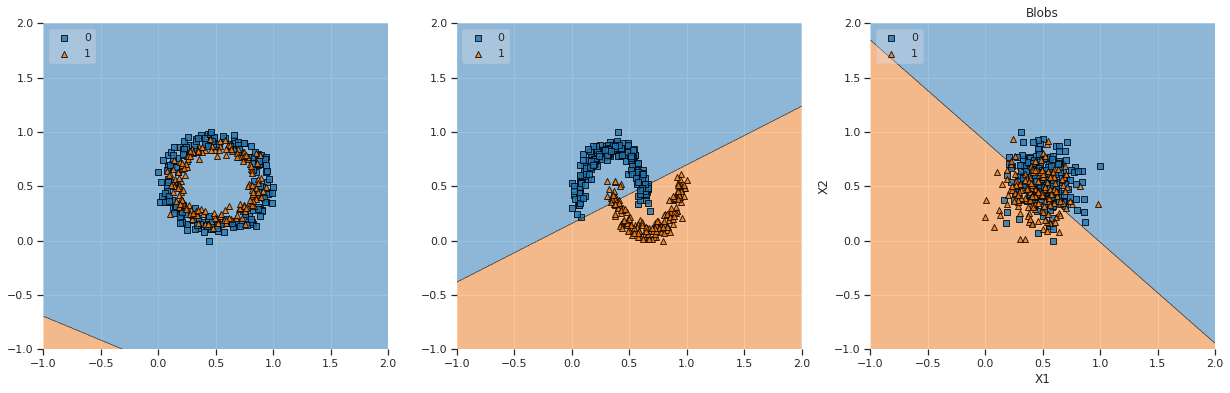

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

import warnings
warnings.filterwarnings("ignore")

### Initialize PP instances
no_poly = 1
no_sel_fts = 2

sclr_01 = MinMaxScaler()
polyFt_m = PolynomialFeatures(no_poly,include_bias=False)

### Initialize Ft Selection
sel = SelectKBest(chi2, k=no_sel_fts)

fig, axs = plt.subplots(1,3,figsize=(21,6))

### Initialize Model
model = LogisticRegression()

### Block 1 -----
X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)
model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, legend=2, ax = axs[0]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circles')
### Block 1 -----

### Block 2 -----
X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, legend=2, ax = axs[1]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Moons')
### Block 2 -----

### Block 3 -----
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
                                                    test_size=0.3, 
                                                    random_state=1)
X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, legend=2, ax = axs[2]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Blobs')
### Block 3 -----

plt.show();

### 2.1.2. Árbol de Decisión

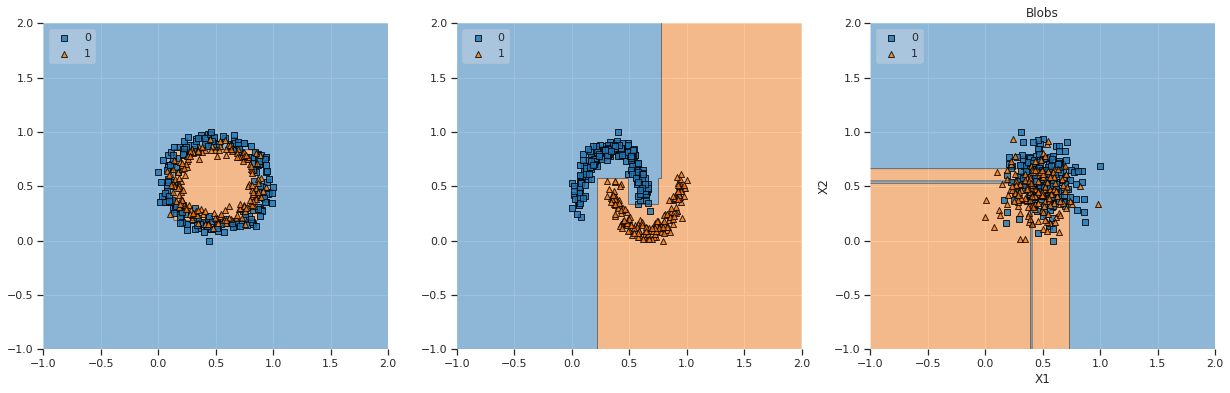

In [ ]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

import warnings
warnings.filterwarnings("ignore")

### Initialize PP instances
no_poly = 1
no_sel_fts = 2

sclr_01 = MinMaxScaler()
polyFt_m = PolynomialFeatures(no_poly,include_bias=False)

### Initialize Ft Selection
sel = SelectKBest(chi2, k=no_sel_fts)

### Initialize Model
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=5,
                               min_samples_split = 20, 
                               random_state=0)

### Initialize Figs
fig, axs = plt.subplots(1,3,figsize=(21,6))

### Block 1 -----
X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, 
                      legend=2, ax = axs[0]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circles')
### Block 1 -----

### Block 2 -----
X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model, 
                      legend=2, ax = axs[1]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Moons')
### Block 2 -----

### Block 3 -----
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
                                                    test_size=0.3, 
                                                    random_state=1)
X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[2]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Blobs')
### Block 3 -----

plt.show();

### 2.1.3. K-Vecinos Cercanos

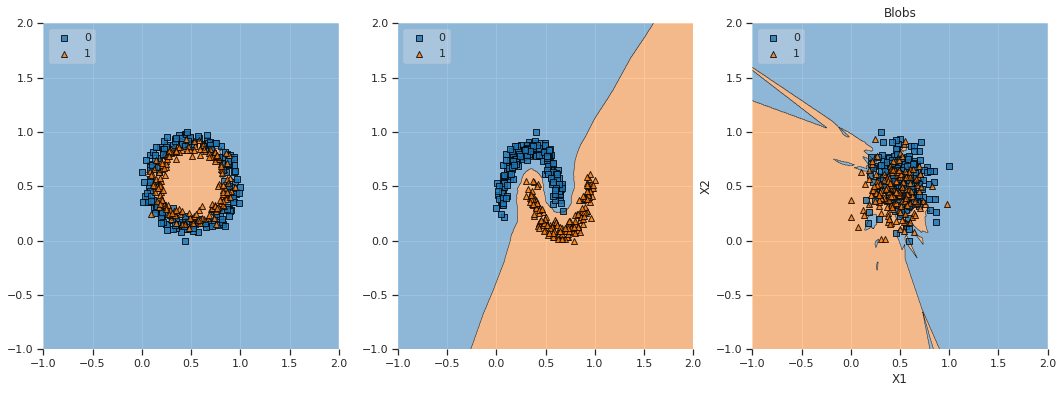

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

import warnings
warnings.filterwarnings("ignore")

### Initialize PP instances
no_poly = 1
no_sel_fts = 2

sclr_01 = MinMaxScaler()
polyFt_m = PolynomialFeatures(no_poly,include_bias=False)

### Initialize Ft Selection
sel = SelectKBest(chi2, k=no_sel_fts)

### Initialize Model
model = KNeighborsClassifier(n_neighbors=5)

fig, axs = plt.subplots(1,3,figsize=(18,6))

### Block 1 -----
X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[0]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circles')
### Block 1 -----

### Block 2 -----
X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[1]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Moons')
### Block 2 -----

### Block 3 -----
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
                                                    test_size=0.3, 
                                                    random_state=1)
X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[2]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Blobs')
### Block 3 -----

plt.show();

### 2.1.4. Máquinas de Vectores Soporte (SVM)

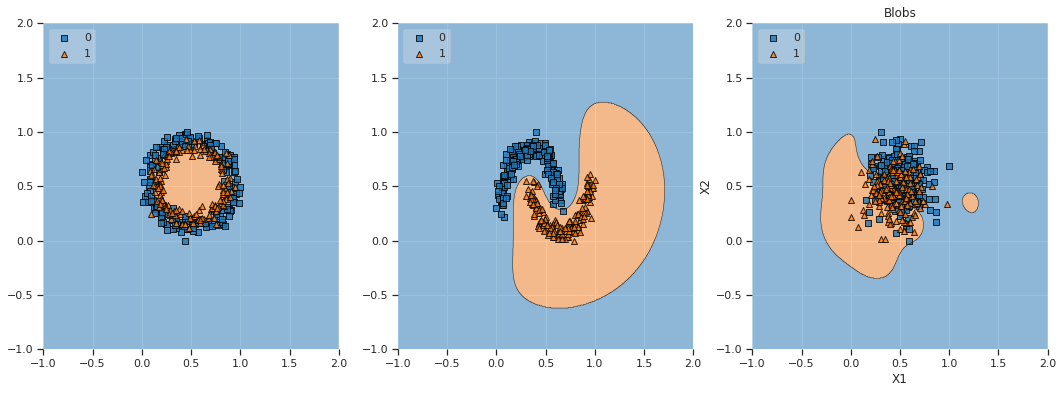

In [ ]:
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

import warnings
warnings.filterwarnings("ignore")

### Initialize PP instances
no_poly = 1
no_sel_fts = 2

sclr_01 = MinMaxScaler()
polyFt_m = PolynomialFeatures(no_poly,include_bias=False)

### Initialize Ft Selection
sel = SelectKBest(chi2, k=no_sel_fts)

### Initialize Model
# model = SVC(C=10.0, kernel='linear')
# model = SVC(C=10, kernel='poly',degree=3)
model = SVC(C=1.5, kernel='rbf', gamma='scale')
# model = SVC(C=10.0, kernel='sigmoid')

fig, axs = plt.subplots(1,3,figsize=(18,6))

### Block 1 -----
X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[0]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circles')
### Block 1 -----

### Block 2 -----
X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
                                                    test_size=0.3, 
                                                    random_state=1)

X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[1]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Moons')
### Block 2 -----

### Block 3 -----
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
                                                    test_size=0.3, 
                                                    random_state=1)
X_train_tmp = sclr_01.fit_transform(X_train)
X_train_tmp = polyFt_m.fit_transform(X_train_tmp)

X_train_sel = sel.fit_transform(X_train_tmp, y_train)

model.fit(X_train_sel,y_train)

# Plotting decision regions
plot_decision_regions(X_train_sel, y_train, clf=model,
                      legend=2, ax = axs[2]);
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Blobs')
### Block 3 -----

plt.show();

---
### Evaluación de Clasificadores: 

#### a) Matriz de Confusión

<img src="https://docs.google.com/uc?export=download&id=1u_i_kvdUCeB5pykkGkjRcJwaRbHPVkIR" width="900" align="middle">

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
f1-score:  1.0


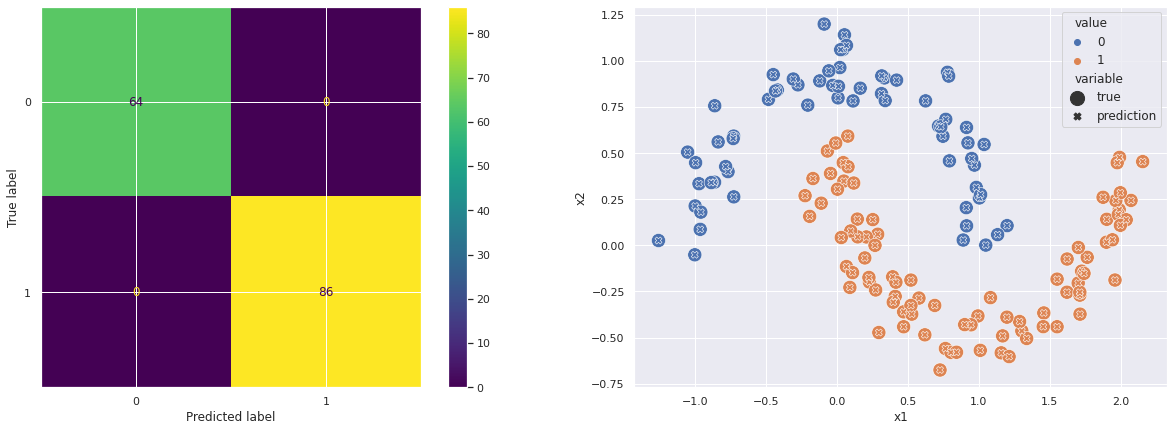

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

# X_train, X_test, y_train, y_test = train_test_split(X_circ, y_circ, 
#                                                     test_size=0.3, 
#                                                     random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_moon, y_moon, 
                                                    test_size=0.3, 
                                                    random_state=1)

# X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, 
#                                                     test_size=0.3, 
#                                                     random_state=1)

# model = LogisticRegression()
# model = DecisionTreeClassifier(criterion='entropy',
#                                max_depth=5,
#                                min_samples_split = 20, 
#                                random_state=0)
model = KNeighborsClassifier(n_neighbors=5)
# model = SVC(C=10, kernel='rbf', gamma='scale')

model.fit(X_train,y_train)

# make a prediction
yhat = model.predict(X_test)

print('Accuracy: ',accuracy_score(y_test[:], yhat[:]))
print('Precision: ',precision_score(y_test[:], yhat[:], average='binary'))
print('Recall: ',recall_score(y_test[:], yhat[:], average='binary'))
print('f1-score: ',f1_score(y_test[:], yhat[:]))

res_df = pd.DataFrame({'x1': X_test[:,0],
                         'x2': X_test[:,1],  
                         'true': y_test[:],
                         'prediction': yhat[:]})

res_df_mlt = pd.melt(res_df,
                       id_vars=['x1','x2'],
                       value_vars=['true', 'prediction'])

# print(res_df_mlt.head())

fig, axs = plt.subplots(1,2,figsize=(21,7))
disp = plot_confusion_matrix(model, X_test, y_test,
                            #  display_labels=['1','0'],
                             cmap=plt.cm.viridis,ax=axs[0], normalize = None
                            #  normalize = 'all'
                            )

sns.scatterplot(x="x1", y="x2", hue="value", style= 'variable', size='variable', sizes=[200,50],
                     data=res_df_mlt, ax=axs[1])

Text(0.5, 1.0, '2-class ROC curve')

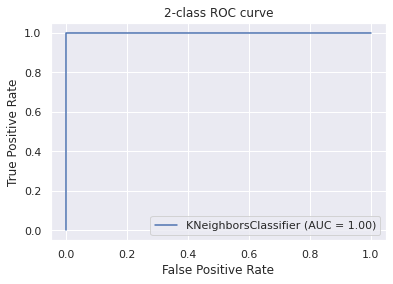

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

disp = plot_roc_curve(model, X_test, y_test)
disp.ax_.set_title('2-class ROC curve')

---
## 2.2. Usos de la Validación Cruzada para Clasificación

<img src="https://docs.google.com/uc?export=download&id=1SYRmAT3I0Qlrwl6kauBqOBlwfhEzMEWG" width="500" align="middle">

### 2.2.1. Como métrica de error en la Selección de Variables Recursivas

Optimal number of features : 7
[19 15  1 11 10  9  6  1  8  2 12 16 17 14  3  1  7  5  1  1  4  1  1 13
 18]


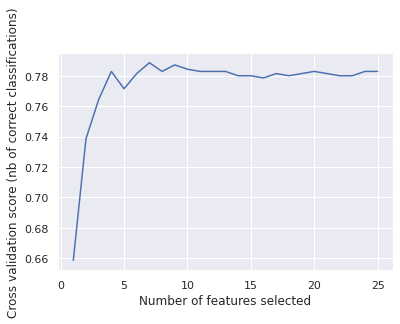

0.75


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

# Build a classification task using N informative features
X_rand, y_rand = make_classification(n_samples=1000, 
                                     n_features=25, 
                                     n_informative=3,
                                     n_redundant=16, n_repeated=4, 
                                     n_classes=2, class_sep=0.2,
                                     n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
# model = LogisticRegression()
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=8,
                               min_samples_split = 20, 
                               random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_rand, y_rand, 
                                                    test_size=0.3, 
                                                    random_state=1)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1, cv=10,
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

X_train_rfecv = rfecv.fit_transform(X_train, y_train)
model.fit(X_train_rfecv, y_train)

X_test_rfecv = rfecv.transform(X_test)
yhat = model.predict(X_test_rfecv)

print(accuracy_score(y_test, yhat))

### 2.2.2. Sintonización de Parámetros 

#### a) Búsqueda en Malla (GridSearch)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,classification_report

import numpy as np


# iris = load_iris()
# X, y = load_iris(return_X_y=True);
X, y = load_breast_cancer(return_X_y=True);

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1)


# Set the parameters by cross-validation
# tuned_parameters = [{'n_neighbors': np.arange(2, 10, 1), 
#                      'p': [1, 2]},
#                     {'n_neighbors': [2,5,10,20],
#                      'algorithm': ['kd_tree'],
#                      'leaf_size': [20, 30,40]}]

tuned_parameters = [{'C': np.arange(1, 10, 3), 
                     'kernel': ['linear', 'rbf']},
                    {'C': np.arange(1, 10, 3), 
                     'kernel': ['poly', 'sigmoid'],
                     'coef0': [1,2],
                     'degree': [2,3]}]


# clf = GridSearchCV(KNeighborsClassifier(),
#                    tuned_parameters, 
#                    scoring='accuracy')
clf = GridSearchCV(SVC(),
                   tuned_parameters, 
                   scoring='accuracy')

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Predict:")
print()
y_true, y_hat = y_test, clf.predict(X_test)
print(accuracy_score(y_true, y_hat))
print()
print(classification_report(y_true, y_hat))

{'C': 1, 'kernel': 'linear'}


---
# 3. Ejercicio/Tarea: Predecir si un pasajero del Titanic Sobrevive

<img src="https://docs.google.com/uc?export=download&id=1VE0J-XRaWvFf5g-FDRrn4SJDgkAg5Zcx" width="500" align="middle">

### a) **Objetivos**: 

- Predecir si un pasajero del Titanic sobrevive usando el conjunto ``X_test`` y los 3 algoritmos (KNN/LR/DT) utilizando todos/algunos/ninguno de los conceptos de preprocesamiento. 
- Elija el mejor modelo para realizar las predicciones.
- Si utilizan algún tipo de selección de variables, deben indicar los nombres de las variables seleccionadas.

### b) **Entregales**:

1. El notebook con los modelos desarrollados.
2. Un vector ``y_hat`` con las predicciones para el mejor modelo.

### Evaluación:

1. Los modelos serán evaluados usando **precision**, **recall**, **f1-measure**.

2. Dentro de 2 semanas se publicaran la lista de resultados.
Nota: Pueden usar pseudonimos para la lista de resultados.


El contenido de este conjunto es el siguiente:

- $y$: ``survival``
- $X$: ``cols``$\neq$``survival``

<img src="https://docs.google.com/uc?export=download&id=1siU1W5_j6f5461ywoKoaaXNkCnWsH547" width="700" align="middle">


[Más información del titanic](https://www.kaggle.com/c/titanic)

#### Datos de Entrenamiento del Conjunto Titanic

In [ ]:
import pandas as pd
import numpy as np
from google.colab import data_table

url = 'https://raw.githubusercontent.com/Alveuz/RandomDataSets/master/Titanic/TitanicTrain.csv'
ttnc_df = pd.read_csv(url)

data_table.DataTable(ttnc_df, include_index=True, num_rows_per_page=10)

,age,fare,embarked,cabin,pclass,sex,sibsp,parch,ticket,survival
0,25.0000,7.9250,S,missing,3,male,0,0,STON/O 2. 3101291,0
1,41.0000,134.5000,C,E40,1,female,0,0,16966,1
2,28.0000,7.7333,Q,missing,3,male,0,0,334912,0
3,18.0000,7.7750,S,missing,3,female,0,0,347087,0
4,29.0000,21.0000,S,missing,2,male,1,0,11668,0
...,...,...,...,...,...,...,...,...,...,...
1042,0.1667,20.5750,S,missing,3,female,1,2,C.A. 2315,1
1043,28.0000,8.0500,S,missing,3,male,0,0,376563,0
1044,28.0000,7.7333,Q,missing,3,female,0,0,335432,1
1045,20.0000,36.7500,S,missing,2,female,0,0,C.A. 33112,1


#### Datos de Prueba del Conjunto Titanic

In [ ]:
import pandas as pd
import numpy as np
from google.colab import data_table

url = 'https://raw.githubusercontent.com/Alveuz/RandomDataSets/master/Titanic/TitanicTest.csv'
ttnc_df = pd.read_csv(url)

data_table.DataTable(ttnc_df, include_index=True, num_rows_per_page=10)

,age,fare,embarked,cabin,pclass,sex,sibsp,parch,ticket
0,38.0,7.8958,S,missing,3,male,0,0,349249
1,21.0,21.0000,S,missing,2,female,0,1,S.O./P.P. 2
2,42.0,27.0000,S,missing,2,male,1,0,243847
3,28.0,14.5000,S,missing,3,male,0,0,364498
4,25.0,31.5000,S,missing,2,male,0,0,C.A. 31029
...,...,...,...,...,...,...,...,...,...
257,22.0,8.0500,S,missing,3,male,0,0,SC/A4 23568
258,28.0,7.8958,S,missing,3,male,0,0,349218
259,30.0,13.0000,S,missing,2,male,0,0,250653
260,26.0,13.0000,S,missing,2,male,0,0,248659
